# Exploring possibilities with `topojson`
Going to take a look at whether it is possible to make a topological data structure backing the tilings. Steps involved:

+ Initial exploration of converting a TileUnit to a `topojson` object and back again (i.e. retrieve the points, edges, faces) - DONE at 27/11/23
+ Look into shapely's new precision options - and generally rationalise the various hacks for keeping polygons clean - DONE 15/12/23 (keep an eye on it for errors, of course...)
+ Build said data structure from clean polgons
+ Explore 'wobbly' edge use-case

In [15]:
%matplotlib inline

import geopandas as gpd

from weavingspace.topology import Topology
from weavingspace import TileUnit
from weavingspace import WeaveUnit
import weavingspace.tiling_utils as tiling_utils

In [16]:
tile = TileUnit(
  # tiling_type = "hex-colouring", n = 3, dissection_offset = 1
  # tiling_type = "square-colouring", n = 5, dissection_offset = 1
  # tiling_type = "hex-dissection", n = 3, dissection_offset = 1
  # tiling_type = "hex-dissection", n = 12, dissection_offset = 0
  # tiling_type = "archimedean", code = "4.6.12"
  tiling_type = "archimedean", code = "3.3.4.3.4"
  # tiling_type = "laves", code = "3.3.3.3.6"
  # tiling_type = "archimedean", code = "4.8.8"
  # tiling_type = "cairo"
)
# tile = WeaveUnit(weave_type = "twill", n = 3, strands = "abc|def")
# tile.plot(r = 1)

/Users/osullid3/miniconda3/envs/weaving/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


In [17]:
topo = Topology(tile)

<Axes: >

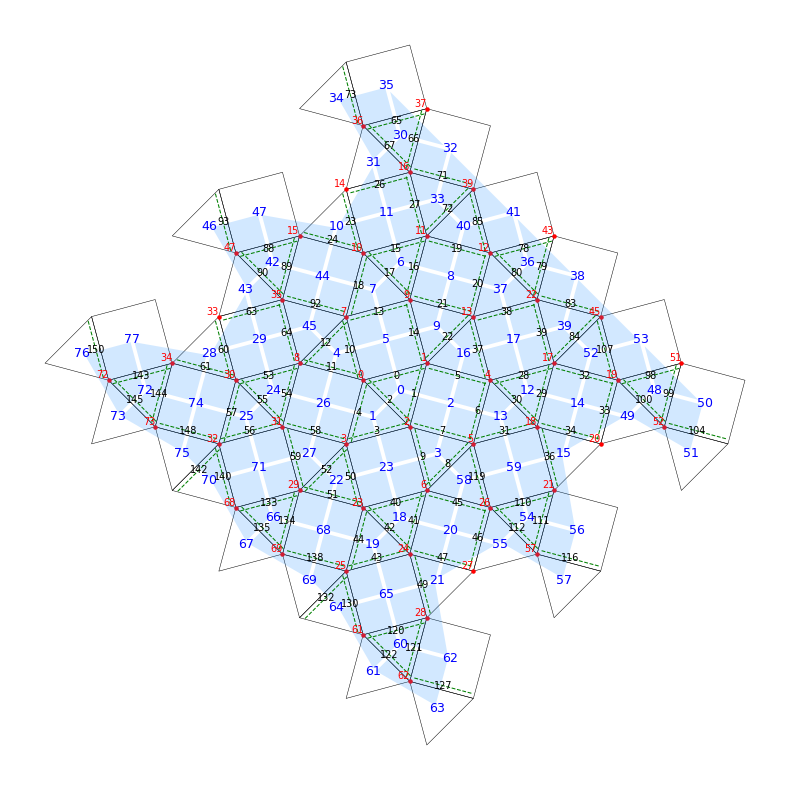

In [18]:
topo.plot(show_dual_polygons = True, 
          show_all_edges = False, show_all_vertices = False)